#Disclaimer
Some of this code is taken by: https://github.com/matteodonati/applications-of-artificial-intelligence-lab

## Libraries

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import random
from google.colab import drive
from scipy.signal import resample
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from copy import deepcopy
import os

## Utilities for data augmentation

This code cell defines three classes (`Stretch`, `Amplify`, and `Augment`) for randomly augmenting input signals.

In [2]:
# Randomly stretches the signal.
class Stretch:
    """
    Taken from:
        https://github.com/matteodonati/applications-of-artificial-intelligence-lab
    """
    def __init__(self):
        pass

    def __call__(self, x):
        n = x.shape[0]
        l = int(n * (1 + (random.random() - 0.5) / 3))
        y = resample(x, l)
        if l < n:
            y_ = np.zeros(shape=(n,))
            y_[:l] = y
        else:
            y_ = y[:n]
        return y_

    def __repr__(self):
        return 'Stretch'

# Randomly amplifies the signal.
class Amplify:
    """
    Taken from:
        https://github.com/matteodonati/applications-of-artificial-intelligence-lab
    """
    def __init__(self):
        pass

    def __call__(self, x):
        alpha = (random.random() - 0.5)
        factor = -alpha * x + (1 + alpha)
        return x * factor

    def __repr__(self):
        return 'Amplify'

# Randomly augments the input signal.
class Augment:
    """
    Taken from:
        https://github.com/matteodonati/applications-of-artificial-intelligence-lab
    """
    def __init__(self, aug_list, verbose=False):
        self.aug_list = aug_list
        self.verbose = verbose

    def __call__(self, x):
        augs = ''
        for i, aug in enumerate(self.aug_list):
            if np.random.binomial(1, 0.5) == 1:
                x = aug(x)
                augs += f'{aug}, ' if i < len(self.aug_list) - 1 else f'{aug}'
        if not self.verbose:
            return x
        return x, augs

The `CustomDataset` class encapsulates the functionality required to prepare custom data for training deep learning models in PyTorch.

In [3]:
class CustomDataset(Dataset):
    """
    Taken and modified from:
        https://github.com/matteodonati/applications-of-artificial-intelligence-lab
    """

    def __init__(self, x, y=None, transforms=None):
        super().__init__()
        self.x = x
        # Remap targets to start from 0 for class weights (RANDOM SAMPLING)
        # class 1 -> 0
        # class 2 -> 1
        # class 3 -> 2
        train_targets = list(df_train[str(df_train.shape[1] - 1)])
        target_mapping = {val: idx for idx, val in enumerate(np.unique(train_targets))}
        self.y = pd.Series([target_mapping[label] for label in y])  # Applica la rimappatura
        self.transforms = transforms

    def __len__(self):
        return len(self.x)  # Use len() function to get the length of the dataset

    def __getitem__(self, idx):
        """
        if not isinstance(idx, int):
            raise ValueError(f"Index {idx} must be an integer")
        """

        if idx < 0 or idx >= len(self):  # Check if index is within valid range
            #raise IndexError("Index out of bounds")

            # Handle out-of-bounds index
            # Skip the problematic sample
            return self.__getitem__((idx + 1) % len(self))  # Skip to the next sample

        x = self.x.iloc[idx, :]
        if self.transforms is not None:
            x = self.transforms(x)
        x = torch.tensor(np.array(x)).float().unsqueeze(-1)

        if self.y is not None:
            y = torch.tensor([self.y.iloc[idx]]).type(torch.LongTensor).squeeze()
        else:
            y = None

        return x, y

## Data

DATASET: https://physionet.org/content/butqdb/1.0.0/#files-panel

In [4]:
drive.mount('/content/drive', force_remount=True)
but_qdb_path = "/content/drive/MyDrive/APPUNTI_LEZIONI/AIA - Applicazioni di IA/progetto/datasets/BUT-QDB-1.0.0"
dataset_path = "/content/drive/MyDrive/APPUNTI_LEZIONI/AIA - Applicazioni di IA/progetto/preprocessing/dataset.csv"
processed_dataset_path = "/content/drive/MyDrive/APPUNTI_LEZIONI/AIA - Applicazioni di IA/progetto/preprocessing/dataset_processed.csv"

Mounted at /content/drive


In [5]:
df = pd.read_csv(processed_dataset_path)
df

,0,1,2,3,4,5,6,7,8,9,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500
0,-0.438138,0.618891,0.311601,0.470097,0.330869,0.444004,0.337303,0.404934,0.325823,0.382354,...,-0.553014,-0.506705,-0.553322,-0.456354,-0.523623,-0.421482,-0.530643,-0.333371,-0.628572,1.0
1,-0.551117,-0.329635,-0.397577,-0.373191,-0.399101,-0.391066,-0.403648,-0.389575,-0.387534,-0.373725,...,-0.642803,-0.592077,-0.577079,-0.602867,-0.591623,-0.510817,-0.540661,-0.476087,-0.568999,2.0
2,-0.108788,-0.259244,-0.182802,-0.220931,-0.203066,-0.227950,-0.202632,-0.215205,-0.212058,-0.215222,...,-0.117645,-0.144758,-0.129717,-0.147656,-0.123460,-0.111011,-0.108106,-0.137789,-0.087755,2.0
3,-0.139145,-0.334940,-0.303401,-0.400829,-0.413991,-0.424679,-0.443348,-0.485302,-0.483783,-0.512934,...,-1.000000,-0.991821,-0.885317,-0.741884,-0.575676,-0.470824,-0.379897,-0.443199,-0.432753,2.0
4,-0.274404,-0.480679,-0.732988,-0.717777,-0.731522,-0.712511,-0.737910,-0.741917,-0.757853,-0.776206,...,-0.596551,-0.592740,-0.609229,-0.661037,-0.695323,-0.684173,-0.652609,-0.473698,-0.302491,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32951,0.100446,0.117015,0.121247,0.142377,0.141766,0.147383,0.151664,0.157520,0.156751,0.153292,...,-0.495954,-0.515633,-0.531056,-0.553070,-0.565477,-0.573951,-0.577206,-0.567234,-0.558436,1.0
32952,-0.116962,-0.101911,-0.093453,-0.086774,-0.076941,-0.068891,-0.063290,-0.052928,-0.049481,-0.045876,...,-0.173669,-0.162429,-0.153022,-0.139698,-0.122872,-0.108316,-0.093808,-0.082545,-0.076810,1.0
32953,-0.177759,-0.183084,-0.206478,-0.227821,-0.263806,-0.316868,-0.272228,-0.095946,0.087111,0.330160,...,-0.149319,-0.164652,-0.177347,-0.195834,-0.205244,-0.214755,-0.215130,-0.214387,-0.202264,1.0
32954,-0.043413,-0.034304,-0.033921,-0.028183,-0.034511,-0.026424,-0.018008,-0.007777,-0.001952,0.008577,...,-0.161284,-0.168484,-0.168377,-0.162559,-0.156203,-0.147757,-0.132384,-0.103830,-0.101764,1.0


Lets visualize a portion of the dataset.

In [6]:
def plot_sample_data(df, labels_map):
    # Plot some data.
    rows, cols = 3, 3
    fig, ax = plt.subplots(rows, cols, figsize=(20, 15), sharex=True, sharey=True)

    for r in range(rows):

        for c in range(cols):
            # pandas.DataFrame.sample return a random sample of items from an axis of object
            rnd_sample = df.sample(1) # prendo una riga random (1 serie temporale)
            values = rnd_sample.values.flatten()
            # l'ultimo elemento contiene il numero corrispondente alla label vera
            y = labels_map[values[-1]]
            # escludo dal plot la label (ultimo elem)
            x = values[:-1]
            ax[r, c].plot(x)
            ax[r, c].set_title(y)

    # add grids
    for a in ax.flat:
        a.grid(True)

    plt.savefig('/content/dataset_overview.png')
    plt.show()

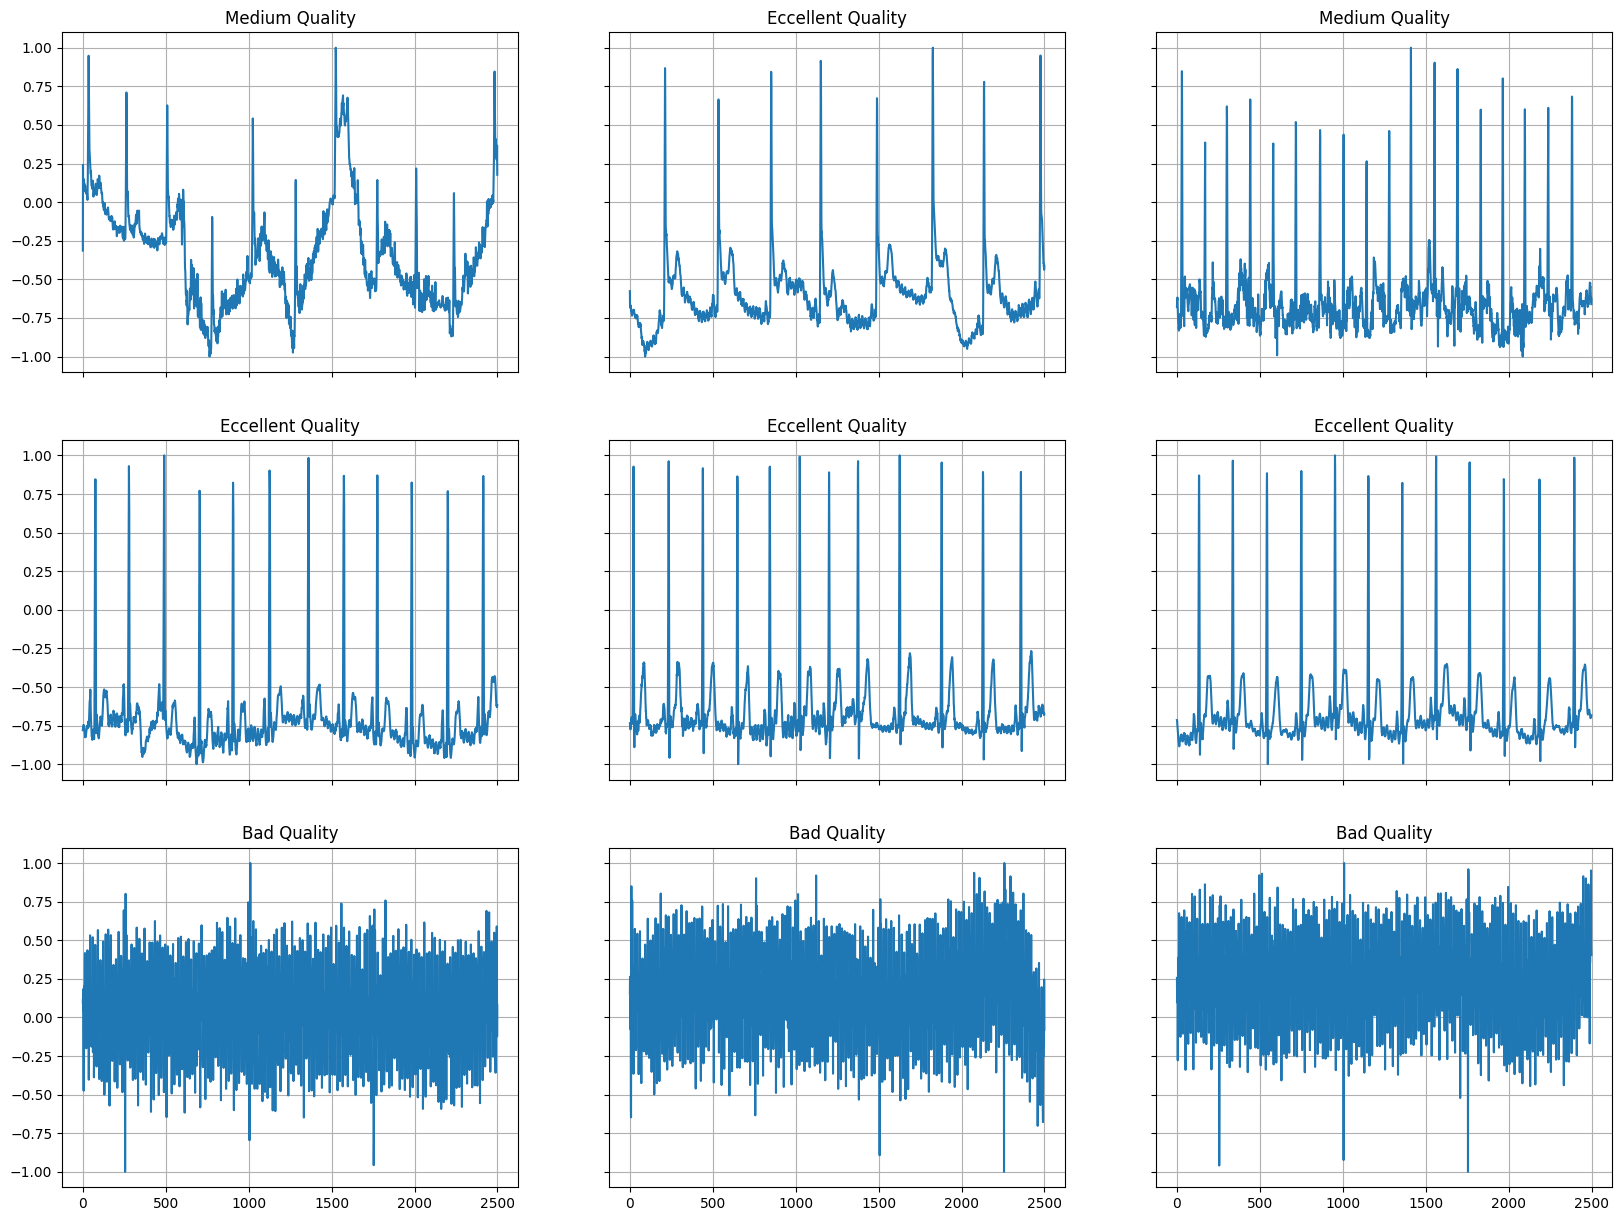

In [27]:
# numbers to class mapping
labels_map = {1 : 'Eccellent Quality', 2 : 'Medium Quality', 3 : 'Bad Quality', 0 : 'Not annotated'}

# plot some samples from dataset
plot_sample_data(df, labels_map)

In [8]:
# random split df into train, test and validation set -> 70 : 20 : 10 %

# 70 % train set -> 30 % = 0.3 test and validation set
df_train, df_test_val = train_test_split(df, test_size=0.3, random_state=42)

# validation and test set (1/3 = 0.33 is for validation)
df_test, df_val = train_test_split(df_test_val, test_size=0.33, random_state=42)

# Verifica delle dimensioni
print(f"Training set size: {df_train.shape}")
print(f"Validation set size: {df_val.shape}")
print(f"Test set size: {df_test.shape}")

Training set size: (23069, 2501)
Validation set size: (3263, 2501)
Test set size: (6624, 2501)


In [9]:
def class_distribution(df):
    return df.iloc[:, -1].value_counts()

In [10]:
class_distribution(df_train)

,count
2500,
1.0,11944
2.0,7463
3.0,3662


The distribution of classes in our dataset is **significantly imbalanced** as you can see in the histogram below.

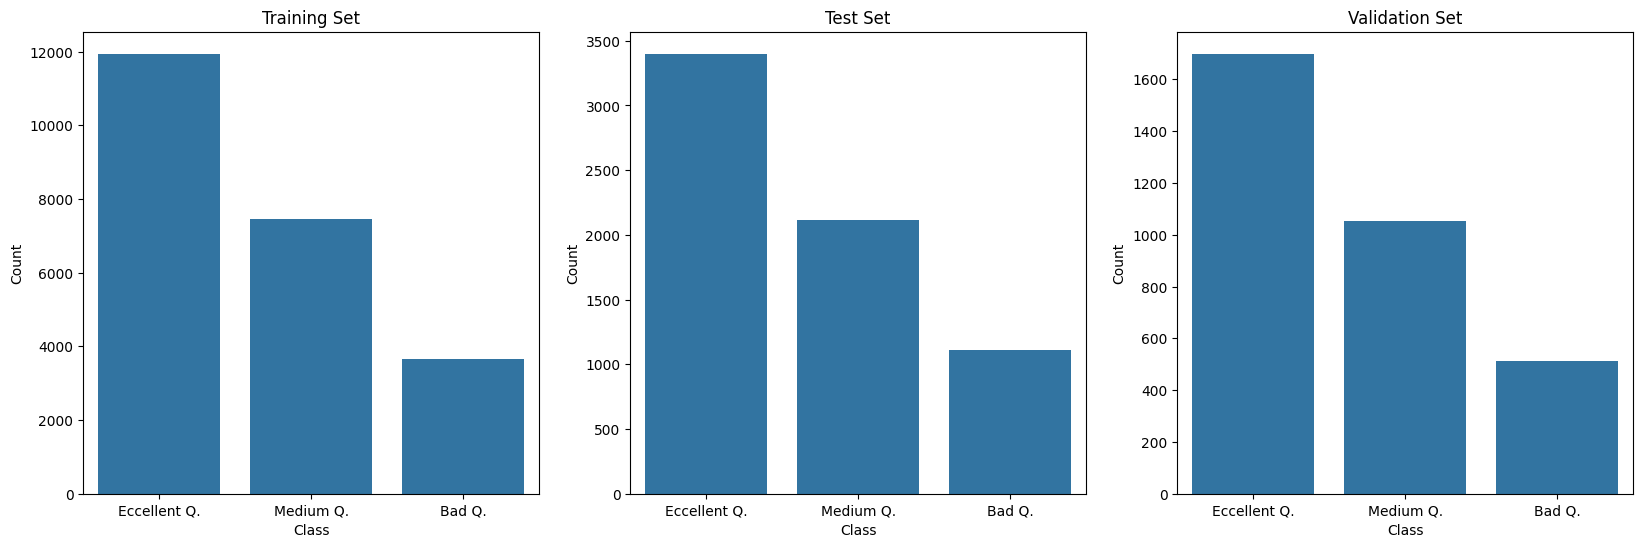

In [11]:
short_labels_map = {'1.0' : 'Eccellent Q.', '2.0' : 'Medium Q.', '3.0' : 'Bad Q.'}

# Plot distributions.
fig, ax = plt.subplots(1, 3, figsize=(20, 6))
sns.countplot(x=df_train[str(df_train.shape[1] - 1)], ax=ax[0])
sns.countplot(x=df_test[str(df_test.shape[1] - 1)], ax=ax[1])
sns.countplot(x=df_val[str(df_val.shape[1] - 1)], ax=ax[2])
# training plot
ax[0].set_title('Training Set')
ax[0].set_xlabel('Class')
ax[0].set_ylabel('Count')
ax[0].set_xticks(list(short_labels_map.keys()))
ax[0].set_xticklabels(list(short_labels_map.values()))
# test plot
ax[1].set_title('Test Set')
ax[1].set_xlabel('Class')
ax[1].set_ylabel('Count')
ax[1].set_xticks(list(short_labels_map.keys()))
ax[1].set_xticklabels(list(short_labels_map.values()))
# validation plot
ax[2].set_title('Validation Set')
ax[2].set_xlabel('Class')
ax[2].set_ylabel('Count')
ax[2].set_xticks(list(short_labels_map.keys()))
ax[2].set_xticklabels(list(short_labels_map.values()))
# save figure
plt.savefig('/content/class_distribution.png')
plt.show()

We define the batch size and then create the `Dataset` objects.

In [12]:
# Batch size.
batch_size = 64

# New Augment object.
augment = Augment([Amplify(), Stretch()])

# Dataset objects.
train_dataset = CustomDataset(df_train.iloc[:, :-1], df_train.iloc[:, -1], transforms=augment)
test_dataset = CustomDataset(df_test.iloc[:, :-1], df_test.iloc[:, -1])
val_dataset = CustomDataset(df_val.iloc[:, :-1], df_val.iloc[:, -1])

We then create the `WeightedRandomSampler` object to perform data augmentation, and define the `DataLoader` objects. This is necessary to obtain good results in case of **unbalanced datasets** like our.



In [13]:
# List of training labels.
train_targets = list(df_train[str(df_train.shape[1] - 1)])

# Computing class weights based on class frequency.
cls_weights = torch.from_numpy(compute_class_weight('balanced',
                                                    classes=np.unique(train_targets),
                                                    y=train_targets))

# Remap targets to start from 0
# class 1 -> 0
# class 2 -> 1
# class 3 -> 2
target_mapping = {val: idx for idx, val in enumerate(np.unique(train_targets))}
mapped_train_targets = [target_mapping[t] for t in train_targets]

# Resulting array of weights.
# Adjust weights accordingly
weights = cls_weights[mapped_train_targets]

# Weighted random sampler. Used to consider copies of minority classes.
sampler = torch.utils.data.WeightedRandomSampler(weights,
                                                 len(mapped_train_targets),
                                                 replacement=True)

# DataLoader objects.
train_loader = DataLoader(train_dataset, sampler=sampler, batch_size=batch_size) #drop_last = True
test_loader = DataLoader(test_dataset, sampler=sampler, batch_size=batch_size) #drop_last = True
val_loader = DataLoader(val_dataset, sampler=sampler, batch_size=batch_size) #drop_last = True

Let's check the batch size and the shapes of the input tensors and labels.

In [14]:
# check batch size
for batch_data, batch_labels in train_loader:
    print("Dimensioni del batch di dati:", batch_data.size())
    print("Dimensioni del batch di etichette:", batch_labels.size())
    break

Dimensioni del batch di dati: torch.Size([64, 2500, 1])
Dimensioni del batch di etichette: torch.Size([64])


## Model Definition

First, we select the device.

In [15]:
# Device configuration.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### 1D-Convolutional Feature Extractor $+$ LSTM Layer $+$ Classification Head

Here we define a model composed of more 1D-convolutional layers, an LSTM layer, and a final classification head used to produce the classification scores.

### 1D-CNN Feature Extractor architecture

The output of a 1D convolutional layer can be calculate using the following formula:

$$
Lenght_{out} = \Big\lfloor \frac{L_{in} - L_{ker} + 1}{L_{pool}} \Big\rfloor
$$

and the number of output channels will be equal to the number of kernels used by the previous convolutional layer.

In [16]:
# Model hyperparameters.
lstm_hidden_size = 64 # number of LSTM neurons for each layer
lstm_num_layers = 1   # number of layer LSTM
num_classes = 3       # number of output classes

class CNN_LSTM(nn.Module):
    def __init__(self, lstm_hidden_size, lstm_num_layers, num_classes):
        super(CNN_LSTM, self).__init__()

        self.lstm_hidden_size = lstm_hidden_size
        self.lstm_num_layers = lstm_num_layers
        self.num_classes = num_classes
        # length of a single sample
        self.ecg_sample_len = int(df_train.shape[1] - 1)   # 2500

        # Definizione dei layer CNN
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3)
        self.bn1 = nn.BatchNorm1d(32)
        self.pool1 = nn.MaxPool1d(kernel_size=2)

        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(64)
        self.pool2 = nn.MaxPool1d(kernel_size=2)

        self.conv3 = nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(64)
        self.pool3 = nn.MaxPool1d(kernel_size=2)

        self.conv4 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(128)
        self.pool4 = nn.MaxPool1d(kernel_size=2)

        # Calcolo della dimensione dell'input per LSTM dopo i layer CNN
        self.lstm_input_size = self._get_conv_output_size()

        # Definizione dei layer LSTM e Dropout
        self.dropout1 = nn.Dropout(0.7)  # Dropout prima del LSTM
        self.lstm = nn.LSTM(input_size=self.lstm_input_size, hidden_size=self.lstm_hidden_size, num_layers=self.lstm_num_layers, batch_first=True)
        self.dropout2 = nn.Dropout(0.7)  # Dropout dopo il LSTM

        # Definizione dello strato completamente connesso
        self.fc = nn.Linear(self.lstm_hidden_size, self.num_classes)

    # using this function we avoid to calculate each CNN output with formulas
    def _get_conv_output_size(self):
        """
        Function to avoid to calculate the following formula:
            L^out = floor((L_in - L_ker + 1) / L_pool)
        """
        # Calcolo della dimensione dell'output dopo tutti i layer CNN
        sample_input = torch.zeros(1, 1, self.ecg_sample_len)  # Input di esempio con lunghezza 2500
        output = self.pool4(self.bn4(self.conv4(self.pool3(self.bn3(self.conv3(self.pool2(self.bn2(self.conv2(self.pool1(self.bn1(self.conv1(sample_input))))))))))))
        return output.shape[1]  # Dimensione dell'output per ciascun canale (features)

    def forward(self, x):
        # Cambia la forma dell'input per adattarsi ai layer CNN
        # Cambia la forma da [batch_size, sequence_length, channels] a [batch_size, channels, sequence_length]
        x = x.permute(0, 2, 1)

        # Passaggio attraverso i layer convoluzionali
        x = self.pool1(self.bn1(self.conv1(x)))
        x = self.pool2(self.bn2(self.conv2(x)))
        x = self.pool3(self.bn3(self.conv3(x)))
        x = self.pool4(self.bn4(self.conv4(x)))

        # Preparazione per il layer LSTM
        # l'output del layer convoluzionale ha la forma [batch_size, features, sequence_length]
        # Cambia la forma per adattarla a LSTM (batch_size, seq_length, features)
        x = x.permute(0, 2, 1)

        # Dropout prima del LSTM
        x = self.dropout1(x)

        # Passaggio attraverso il layer LSTM
        h0 = torch.zeros(self.lstm_num_layers, x.size(0), self.lstm_hidden_size).to(x.device)
        c0 = torch.zeros(self.lstm_num_layers, x.size(0), self.lstm_hidden_size).to(x.device)
        x, _ = self.lstm(x, (h0, c0))

        # Dropout dopo il LSTM
        x = self.dropout2(x)

        # Passaggio attraverso lo strato completamente connesso
        x = self.fc(x[:, -1, :])  # Utilizziamo solo l'ultimo output di LSTM

        # DA NON METTERE SE USI CROSS ENTROPY LOSS FUNCTION
        # Applicazione della funzione softmax
        #x = torch.softmax(x, dim=1)  # softmax lungo la dimensione delle classi

        return x

# Inizializzazione del modello
model_lstm = CNN_LSTM(lstm_hidden_size, lstm_num_layers, num_classes).to(device)
print(model_lstm)

CNN_LSTM(
  (conv1): Conv1d(1, 32, kernel_size=(3,), stride=(1,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 128, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.7, inplace=False)
  (lstm): LSTM(12

## Training and Test

We define few other parameters:
- The duration of training (`num_epochs`).
- The step at which our model learns (`learning_rate`).

In [17]:
# Training hyperparameters.
num_epochs = 30 # 30
learning_rate = 0.0001 # 0.0001

Lastly, we train and test the model.

In [18]:
def train(epoch, model, train_loader, val_loader, criterion, optimizer, device='cpu'):
    model.train()
    train_loss = 0
    for data in tqdm(train_loader, desc=f'Epoch {epoch+1:03d}'):
        x = data[0].to(device)
        y = data[1].to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    return train_loss / len(train_loader)

def validate(model, loader, criterion, device='cpu'):
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    y_true = []
    y_pred = []
    with torch.no_grad():
        for data in loader:
            x = data[0].to(device)
            y = data[1].to(device)
            out = model(x)
            val_loss += criterion(out, y).item()
            _, pred = torch.max(out, 1)
            total += y.size(0)
            correct += (pred == y).sum().item()
            y_true += y.tolist()
            y_pred += pred.tolist()

    val_loss /= len(loader)
    accuracy = correct / total
    f1 = f1_score(y_true, y_pred, average='macro')

    return val_loss, accuracy, f1, y_true, y_pred

def test(model, loader, criterion, device='cpu'):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    y_true = []
    y_pred = []
    with torch.no_grad():
        for data in loader:
            x = data[0].to(device)
            y = data[1].to(device)
            out = model(x)
            test_loss += criterion(out, y).item()
            _, pred = torch.max(out, 1)
            total += y.size(0)
            correct += (pred == y).sum().item()
            y_true += y.tolist()
            y_pred += pred.tolist()

    test_loss /= len(loader)
    accuracy = correct / total
    f1 = f1_score(y_true, y_pred, average='macro')

    return test_loss, accuracy, f1, y_true, y_pred

In [19]:
# Train, test, validation with early stopping
def train_and_test(n_epochs, model, train_loader, val_loader, test_loader, learning_rate=0.001, patience=5, device='cpu'):

    # Path to save the model after training
    model_path = '/content/best_model.pth'

    # Remove existing model file if exists
    if os.path.exists(model_path):
        os.remove(model_path)

    # Loss and optimizer
    # NON USARE SOFTMAX CON CROSS ENTROPY LOSS (GIA' IMPLICITA)
    criterion = nn.CrossEntropyLoss()  # NNB le etichette delle classi devono partire da 0 !!!
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    best_val_loss = float('inf')
    counter = 0
    best_model_state = deepcopy(model.state_dict())  # Initialize with the current model state

    for epoch in range(n_epochs):

        # Train the model
        train_loss = train(epoch, model, train_loader, val_loader, criterion, optimizer, device)

        # Validate the model
        val_loss, val_acc, val_f1, _, _ = validate(model, val_loader, criterion, device)

        # Test the model
        test_loss, test_acc, test_f1, y_true, y_pred = test(model, test_loader, criterion, device)

        print(f'Epoch {epoch+1:03d}: train loss {train_loss:.4f}, val loss {val_loss:.4f}, '
              f'val acc {val_acc:.4f}, val f1 {val_f1:.4f}, test loss {test_loss:.4f}, '
              f'test acc {test_acc:.4f}, test f1 {test_f1:.4f}')

        # Early stopping logic
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = deepcopy(model.state_dict())  # Save best model state in RAM
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print(">>> Early stopping!")
                break

    # Load the best model state from RAM
    model.load_state_dict(best_model_state)

    # Save the best model state to file
    torch.save(best_model_state, model_path)

    # Verify that the best model parameters were loaded
    val_loss, val_acc, val_f1, _, _ = validate(model, val_loader, criterion, device)
    test_loss, test_acc, test_f1, y_true, y_pred = test(model, test_loader, criterion, device)
    print(50*'#')
    print(f'Best model: train loss {train_loss:.4f}, val loss {val_loss:.4f}, '
          f'val acc {val_acc:.4f}, val f1 {val_f1:.4f}, test loss {test_loss:.4f}, '
          f'test acc {test_acc:.4f}, test f1 {test_f1:.4f}')

    # Return results in a python dictionary
    test_results = [train_loss, val_loss, val_acc, val_f1, test_loss, test_acc, test_f1, y_true, y_pred]
    test_keys = ['train_loss', 'val_loss', 'val_acc', 'val_f1', 'test_loss', 'test_acc', 'test_f1', 'y_true', 'y_pred']
    return dict(zip(test_keys, test_results))

In [31]:
# patience for early stopping
patience = 10 # num of epochs

# Training, validation and testing
lstm_results = train_and_test(num_epochs, model_lstm, train_loader, val_loader, test_loader, learning_rate, patience, device)

Epoch 001: 100%|██████████| 361/361 [00:21<00:00, 16.98it/s]


Epoch 001: train loss 0.3260, val loss 0.3827, val acc 0.8432, val f1 0.8682, test loss 0.3840, test acc 0.8410, test f1 0.8659


Epoch 002: 100%|██████████| 361/361 [00:21<00:00, 16.55it/s]


Epoch 002: train loss 0.3150, val loss 0.2662, val acc 0.9085, val f1 0.9151, test loss 0.2639, test acc 0.9065, test f1 0.9147


Epoch 003: 100%|██████████| 361/361 [00:21<00:00, 16.85it/s]


Epoch 003: train loss 0.3591, val loss 0.3058, val acc 0.8852, val f1 0.8975, test loss 0.3017, test acc 0.8842, test f1 0.8987


Epoch 004: 100%|██████████| 361/361 [00:21<00:00, 17.08it/s]


Epoch 004: train loss 0.3120, val loss 0.2907, val acc 0.8730, val f1 0.8911, test loss 0.2938, test acc 0.8686, test f1 0.8873


Epoch 005: 100%|██████████| 361/361 [00:21<00:00, 16.44it/s]


Epoch 005: train loss 0.3238, val loss 0.2764, val acc 0.8987, val f1 0.9071, test loss 0.2709, test acc 0.9017, test f1 0.9118


Epoch 006: 100%|██████████| 361/361 [00:21<00:00, 16.78it/s]


Epoch 006: train loss 0.2956, val loss 0.2766, val acc 0.8983, val f1 0.9077, test loss 0.2615, test acc 0.8972, test f1 0.9096


Epoch 007: 100%|██████████| 361/361 [00:21<00:00, 16.74it/s]


Epoch 007: train loss 0.3051, val loss 0.2863, val acc 0.8783, val f1 0.8922, test loss 0.2729, test acc 0.8780, test f1 0.8934


Epoch 008: 100%|██████████| 361/361 [00:21<00:00, 16.53it/s]


Epoch 008: train loss 0.2987, val loss 0.5130, val acc 0.8267, val f1 0.8347, test loss 0.5045, test acc 0.8322, test f1 0.8415


Epoch 009: 100%|██████████| 361/361 [00:21<00:00, 16.87it/s]


Epoch 009: train loss 0.3051, val loss 0.2388, val acc 0.9033, val f1 0.9126, test loss 0.2336, test acc 0.9038, test f1 0.9140


Epoch 010: 100%|██████████| 361/361 [00:21<00:00, 17.00it/s]


Epoch 010: train loss 0.3036, val loss 0.2436, val acc 0.9082, val f1 0.9163, test loss 0.2460, test acc 0.9028, test f1 0.9134


Epoch 011: 100%|██████████| 361/361 [00:21<00:00, 16.65it/s]


Epoch 011: train loss 0.2967, val loss 0.3171, val acc 0.8548, val f1 0.8766, test loss 0.3227, test acc 0.8510, test f1 0.8741


Epoch 012: 100%|██████████| 361/361 [00:21<00:00, 17.03it/s]


Epoch 012: train loss 0.2866, val loss 0.3039, val acc 0.8791, val f1 0.8935, test loss 0.2957, test acc 0.8804, test f1 0.8949


Epoch 013: 100%|██████████| 361/361 [00:21<00:00, 16.99it/s]


Epoch 013: train loss 0.2955, val loss 0.7099, val acc 0.5394, val f1 0.5989, test loss 0.6909, test acc 0.5531, test f1 0.6051


Epoch 014: 100%|██████████| 361/361 [00:21<00:00, 16.55it/s]


Epoch 014: train loss 0.3364, val loss 0.3565, val acc 0.8539, val f1 0.8679, test loss 0.3642, test acc 0.8491, test f1 0.8641


Epoch 015: 100%|██████████| 361/361 [00:21<00:00, 17.08it/s]


Epoch 015: train loss 0.3267, val loss 0.2784, val acc 0.8931, val f1 0.9042, test loss 0.2924, test acc 0.8826, test f1 0.8980


Epoch 016: 100%|██████████| 361/361 [00:21<00:00, 16.80it/s]


Epoch 016: train loss 0.2921, val loss 0.2481, val acc 0.9073, val f1 0.9163, test loss 0.2526, test acc 0.9010, test f1 0.9113


Epoch 017: 100%|██████████| 361/361 [00:21<00:00, 16.68it/s]


Epoch 017: train loss 0.2963, val loss 0.2683, val acc 0.8876, val f1 0.9023, test loss 0.2669, test acc 0.8828, test f1 0.9000


Epoch 018: 100%|██████████| 361/361 [00:21<00:00, 17.18it/s]


Epoch 018: train loss 0.2931, val loss 0.2739, val acc 0.9007, val f1 0.9064, test loss 0.2515, test acc 0.9108, test f1 0.9176


Epoch 019: 100%|██████████| 361/361 [00:21<00:00, 16.66it/s]


Epoch 019: train loss 0.3232, val loss 0.2467, val acc 0.9082, val f1 0.9154, test loss 0.2486, test acc 0.9052, test f1 0.9140
>>> Early stopping!
##################################################
Best model: train loss 0.3232, val loss 0.2447, val acc 0.9019, val f1 0.9122, test loss 0.2367, test acc 0.8983, test f1 0.9087


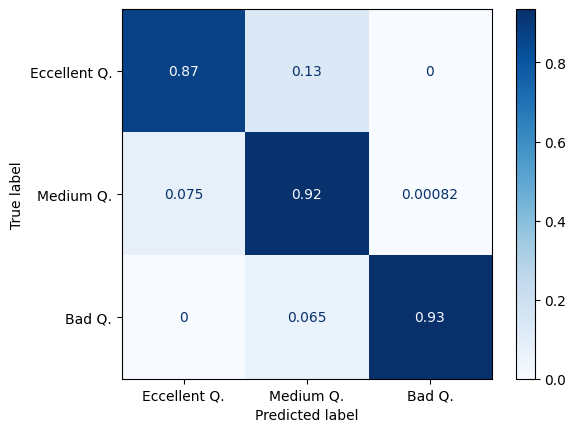

In [32]:
# NNB y_true e y_test sono calcolati sul TEST SET !!!
# confusion matrix (LABELS ARE SHIFTED -1)
reduced_labels_map = {0 : 'Eccellent Q.', 1 : 'Medium Q.', 2 : 'Bad Q.'}
ConfusionMatrixDisplay.from_predictions(lstm_results['y_true'], lstm_results['y_pred'], normalize='true', cmap='Blues', display_labels=reduced_labels_map.values())
plt.savefig('/content/confusion_matrix.png')
plt.show()

In [33]:
# METRICHE SUL TEST SET !!!
print(classification_report(lstm_results['y_true'], lstm_results['y_pred'], zero_division=0, target_names=reduced_labels_map.values()))

              precision    recall  f1-score   support

Eccellent Q.       0.95      0.87      0.91     11821
   Medium Q.       0.79      0.92      0.85      7326
      Bad Q.       1.00      0.93      0.97      3922

    accuracy                           0.90     23069
   macro avg       0.91      0.91      0.91     23069
weighted avg       0.91      0.90      0.90     23069



## Save and Load Models
Documentation: https://pytorch.org/tutorials/beginner/saving_loading_models.html

In [34]:
# Save only the model parameters (RECOMMENDED) into google drive
model_path = "/content/drive/MyDrive/APPUNTI_LEZIONI/AIA - Applicazioni di IA/progetto/model_params.ckpt"
torch.save(model_lstm.state_dict(), model_path)

In [35]:
# recreate models structure (PARAMETERS MUST NOT CHANGE) WITHOUT TRAINED PARAMS
del model_lstm
model_lstm = CNN_LSTM(lstm_hidden_size, lstm_num_layers, num_classes).to(device)

# Try to reload models params from google drive
model_lstm.load_state_dict(torch.load(model_path, weights_only=True))

<All keys matched successfully>

In [25]:
# Creiamo una griglia 3x3 per visualizzare 9 campioni casuali
def plot_sample_predictions(train_loader, model, labels_map):
    # Preparazione della griglia 3x3
    fig, axs = plt.subplots(3, 3, figsize=(15, 10))
    fig.suptitle('Sample Predictions from the Model', fontsize=16)

    count = 0
    for input, label in train_loader:

        # Sposta input e label sul dispositivo specificato (CPU o GPU)
        input = input.to(device)
        label = label.to(device)

        out = model(input)

        for idx, elem in enumerate(out):
            # REMAPPING CLASS
            predicted_class = float(torch.argmax(elem))
            correct_pred_class = predicted_class + 1
            correct_real_class = float(label[idx]) + 1

            # Identificare la posizione sulla griglia (riga, colonna)
            row = count // 3
            col = count % 3

            # Plotting nella griglia, assicurandosi di trasferire a CPU prima di usare numpy()
            axs[row, col].plot(input[idx].detach().cpu().numpy())  # Copia nella memoria host
            if correct_real_class == correct_pred_class:
                axs[row, col].set_title(f'{labels_map[correct_pred_class]} (CORRECT)', color='b')
            else:
                axs[row, col].set_title(f'{labels_map[correct_pred_class]} (CORRECT WAS: {labels_map[correct_real_class]})', color='r')

            axs[row, col].grid()
            count += 1

            if count == 9:  # Dopo aver riempito la griglia 3x3, interrompi il ciclo
                plt.tight_layout()
                plt.savefig('/content/prediction_overview.png')
                plt.show()
                return

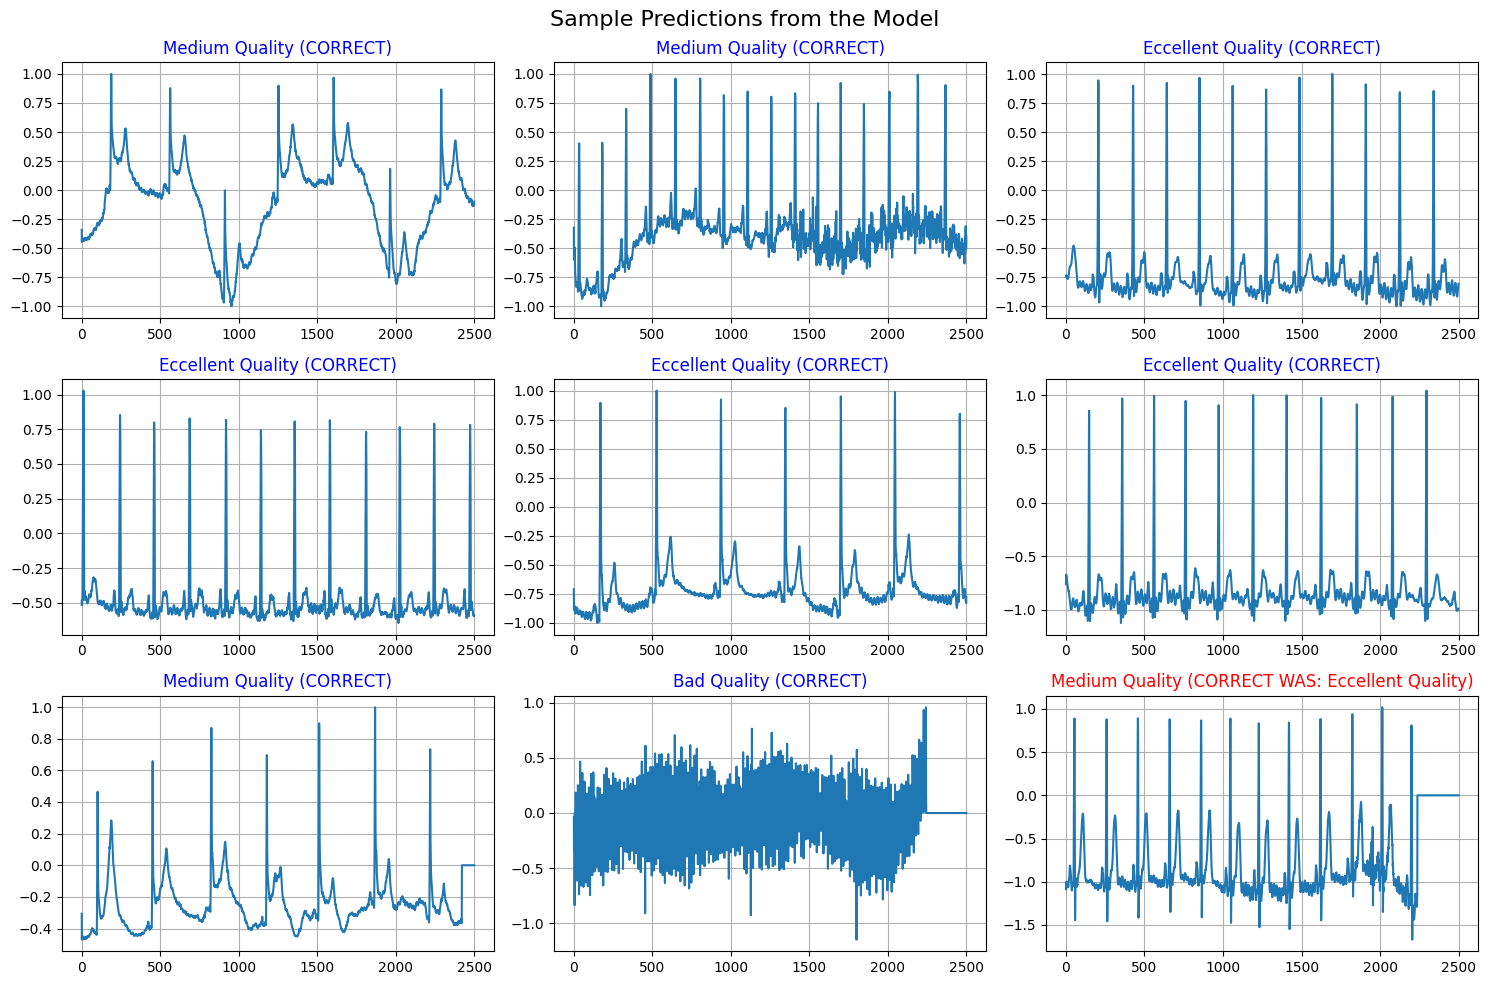

In [26]:
plot_sample_predictions(train_loader, model_lstm, labels_map)